# CS F415 Data Mining - Home Loan Approval

### Problem Statement & Data Set
Suppose a Finance Company offers home loans across urban, semi-urban,
and rural areas. The loan approval process typically spans 1 week to 1 month
due to extensive customer research.To streamline this, we'll employ Data
Mining techniques to automate and expedite loan approvals.

### About the dataset
The loan application data set includes various columns that provide
information on the applicant and the loan, such as Loan ID, Gender, Marital
Status,Dependents, Education, Self-Employment status, Applicant Income,
Co-Applicant Income, Loan Amount, Loan Amount Term, Credit History, and
Property Area.

## Data Preprocessing
### 1. Importing Dependencies and Datasets

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Data
We have two csv files: train & test.

Train file contains all independent variables and target variables which'll be used to train the model. (i.e. train csv has loan_status column, but test csv doesn't)

Test file has independent variables, but not the target variables. This model will predict test variables for the test data.

In [16]:
train=pd.read_csv("./datasets/loan_sanction_train.csv")
test=pd.read_csv("./datasets/loan_sanction_test.csv")

In [17]:
print(train.shape)
train.head(10)

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


#### Checking for duplicates and missing values

In [18]:
print(f"No. of duplicates: {train.duplicated().sum()}")
train.isnull().sum()

No. of duplicates: 0


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

* We have no duplicates, but have several missing values

In [19]:
train.select_dtypes('object').nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64


* Since the value of Loan_Id is unique for each row, we can remove Loan_ID as it won't be useful in model training.

In [20]:
train.drop(columns=['Loan_ID'],inplace=True)

In [21]:
train.describe(include="number") # describing numerical data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [22]:
desc = train.describe(exclude="number") # describing categorical data

for col in desc.columns:
    top_category = desc.loc['top', col]
    percentage = ((train[col] == top_category).mean()*100).round(2)
    desc.loc['top_percentage', col] = percentage

desc

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422
top_percentage,79.64,64.82,56.19,78.18,81.43,37.95,68.73


* There are more Male(79.64%) applicants than Female.
* Frequency of Married(64.82%) applicants is more.
* There are more Graduate(78.18%) applicants.

#### Data Visualization

In [23]:
train['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [24]:
train['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

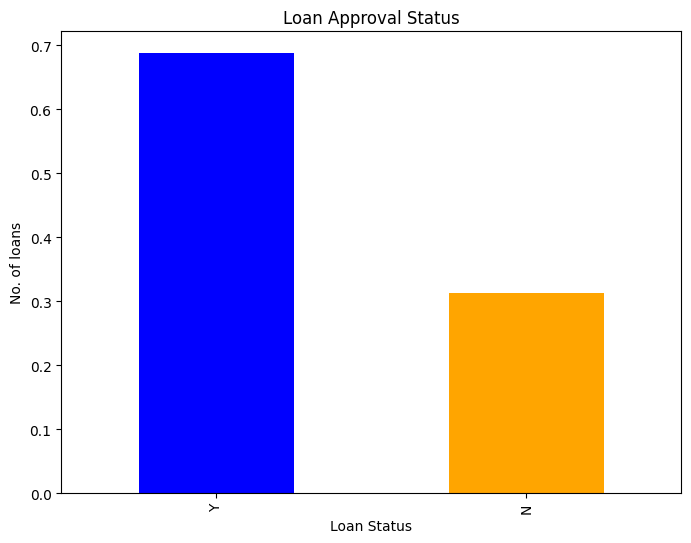

In [25]:
plt.figure(figsize=(8, 6))
train['Loan_Status'].value_counts(normalize=True).plot.bar(color=['blue', 'orange'])
plt.title('Loan Approval Status')
plt.xlabel('Loan Status')
plt.ylabel('No. of loans')
plt.show()

Conclusion: Around 68.72% of people got their loans approved.

 # Gender Distribution

In [26]:
train['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [27]:
train['Gender'].value_counts(normalize=True)

Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64

In [28]:
gender_counts = train['Gender'].value_counts(normalize=True).reset_index()
gender_counts.columns = ['Gender', 'Percentage']

fig = px.bar(gender_counts,
             x='Gender',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Gender',
             color_discrete_sequence=['blue', 'orange'],
             title='Gender Distribution',
             hover_data={'Gender': False, 'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

Around 81.36% of loan applicants are male.

# Martial Status Distribution

In [29]:
#Here we create a dataframe which contains counts and ratios
married_counts = train['Married'].value_counts(normalize=True).reset_index()
married_counts.columns = ['Married', 'Percentage']

fig = px.bar(married_counts,
             x='Married',
             y='Percentage',
             text='Percentage',                           #Percentage on bar graphs
             labels={'Percentage': 'Ratio'},              #Setting the y-axis name
             color='Married',
             color_discrete_sequence=['blue', 'orange'], 
             title='Marital Status Distribution',
             hover_data={'Married': False, 'Percentage': ':.2%'},
             width=800, height=500)

fig.show()

65.13% of people who applied for a loan are married

# Self Employment Status Distribution

In [30]:
self_employed_counts = train['Self_Employed'].value_counts(normalize=True).reset_index()
self_employed_counts.columns = ['Self_Employed', 'Percentage']

fig = px.bar(self_employed_counts,
             x='Self_Employed',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Self_Employed',
             color_discrete_sequence=['#1f77b4', '#ff7f0e'],  
             title='Self Employment Status Distribution',
             hover_data={'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

85.91% of people who applied for a loan are self employed

# Credit History Distribution

In [31]:
credit_history_counts = train['Credit_History'].value_counts(normalize=True).reset_index()
credit_history_counts.columns = ['Credit_History', 'Percentage']

fig = px.bar(credit_history_counts,
             x='Credit_History',
             y='Percentage',
             text='Percentage',
             labels={'Percentage': 'Ratio'},
             color='Credit_History',
             color_discrete_sequence=['blue', 'purple'],
             title='Credit History Distribution',
             hover_data={'Credit_History': False, 'Percentage': ':.2%'},
             width=800, height=500)
fig.show()

around 84.21% of applicants have repayed their depts

### Categorical Distributions

In [32]:
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=1, cols=3, subplot_titles=['Dependents', 'Education', 'Property Area'])

# Dependents
fig.add_trace(go.Bar(x=train['Dependents'].value_counts(normalize=True).index,   #takes unique index values of normalized counts
                     y=train['Dependents'].value_counts(normalize=True),
                     name='Dependents'),
                     row=1, col=1)

# Education
fig.add_trace(go.Bar(x=train['Education'].value_counts(normalize=True).index,
                     y=train['Education'].value_counts(normalize=True),
                     name='Education'),
              row=1, col=2)

# Property Area
fig.add_trace(go.Bar(x=train['Property_Area'].value_counts(normalize=True).index,
                     y=train['Property_Area'].value_counts(normalize=True),
                     name='Property Area'),
              row=1, col=3)

fig.show()

- Lesser part of the applicants have dependents
- 78% of applicants are graduates
- There is no big difference in number of people from semiurban, urban, rural however among them most of the applicants are from semiurban

#### Loan Status by Gender

In [33]:
gender_loan_crosstab = pd.crosstab(train['Gender'], train['Loan_Status'])  #counts the occurences of each combination of genders and loan statuses

# Calculate the percentage distribution
gender_loan_percentage = gender_loan_crosstab.div(gender_loan_crosstab.sum(1).astype(float), axis=0)

#Now we reset the dataframe indices to make it suitable for further processing
gender_loan_percentage.reset_index(inplace=True)

# Create traces for each loan status
trace_not_approved = go.Bar(
    x=gender_loan_percentage['Gender'],
    y=gender_loan_percentage['N'],
    name='Not Approved',
    marker=dict(color='red')
)

trace_approved = go.Bar(
    x=gender_loan_percentage['Gender'],
    y=gender_loan_percentage['Y'],
    name='Approved',
    marker=dict(color='green')
)

layout = go.Layout(
    title='Loan Status by Gender',
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Percentage'),
    barmode='stack',
)

fig = go.Figure(data=[trace_not_approved, trace_approved],layout=layout)
fig.show()

Proportion of male and female applicants is nearly same for both approved and unapproved loans.

#### Loan Approval Status by Categorical Variables

In [34]:
# Crosstabs
married_crosstab = pd.crosstab(train['Married'], train['Loan_Status'])
dependents_crosstab = pd.crosstab(train['Dependents'], train['Loan_Status'])
education_crosstab = pd.crosstab(train['Education'], train['Loan_Status'])
self_employed_crosstab = pd.crosstab(train['Self_Employed'], train['Loan_Status'])

# Normalize Crosstabs
married_normalized = married_crosstab.div(married_crosstab.sum(1).astype(float), axis=0)
dependents_normalized = dependents_crosstab.div(dependents_crosstab.sum(1).astype(float), axis=0)
education_normalized = education_crosstab.div(education_crosstab.sum(1).astype(float), axis=0)
self_employed_normalized = self_employed_crosstab.div(self_employed_crosstab.sum(1).astype(float), axis=0)

# Create subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=['Married', 'Dependents', 'Education', 'Self Employed'],
                       specs=[[{'type': 'bar'}, {'type': 'bar'}],
                              [{'type': 'bar'}, {'type': 'bar'}]])

# Married subplot
fig.add_trace(go.Bar(x=married_normalized.index, y=married_normalized['Y'], name='Approved'),
              row=1, col=1)
fig.add_trace(go.Bar(x=married_normalized.index, y=married_normalized['N'], name='Not Approved'),
              row=1, col=1)
# Dependents subplot
fig.add_trace(go.Bar(x=dependents_normalized.index, y=dependents_normalized['Y'], name='Approved'),
              row=1, col=2)
fig.add_trace(go.Bar(x=dependents_normalized.index, y=dependents_normalized['N'], name='Not Approved'),
              row=1, col=2)

# Education subplot
fig.add_trace(go.Bar(x=education_normalized.index, y=education_normalized['Y'], name='Approved'),
              row=2, col=1)
fig.add_trace(go.Bar(x=education_normalized.index, y=education_normalized['N'], name='Not Approved'),
              row=2, col=1)
# Self Employed subplot
fig.add_trace(go.Bar(x=self_employed_normalized.index, y=self_employed_normalized['Y'], name='Approved'),
              row=2, col=2)
fig.add_trace(go.Bar(x=self_employed_normalized.index, y=self_employed_normalized['N'], name='Not Approved'),
              row=2, col=2)

# Update layout
fig.update_layout(title_text='Loan Approval Status by Categorical Variables',barmode='stack',showlegend=False)

fig.show()

- 71.6% of the married applicants have approved loans where as only 62.9% of loans are approved for unmarried applicants
- Applicants having 2 dependents have higher proportions of loan approval than others
- Graduates have higher proportions of approved loan
- Nothing can be inferred from Self Employed graph

#### Loan Approval Status by Credit History and Property Area

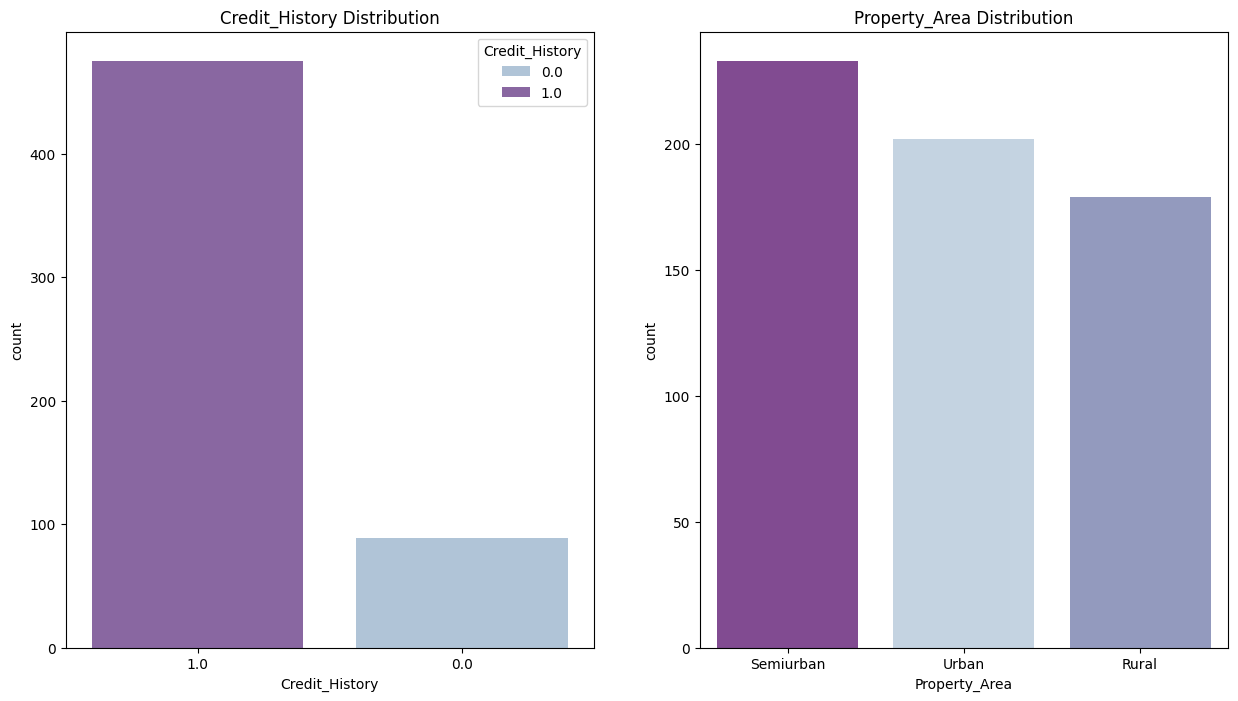

In [35]:
df=train[['Credit_History','Property_Area']]
fig,ax=plt.subplots(1,2,figsize=(15,8))

for i,feature in enumerate(df):
    order=(
        df[feature]
        .value_counts(normalize=True)
        .sort_values(ascending=False).index
    )

    sns.countplot(x=feature, data=df, order=order, ax=ax[i], palette='BuPu',hue=feature)
    ax[i].set_title(f'{feature} Distribution')

- Applicants having Credit History of 1 have far more higher approval percentage than applicants having Credit History 0
- The proportion of loans getting approved in semi-urban areas is higher as compared to that in rural or urban areas.

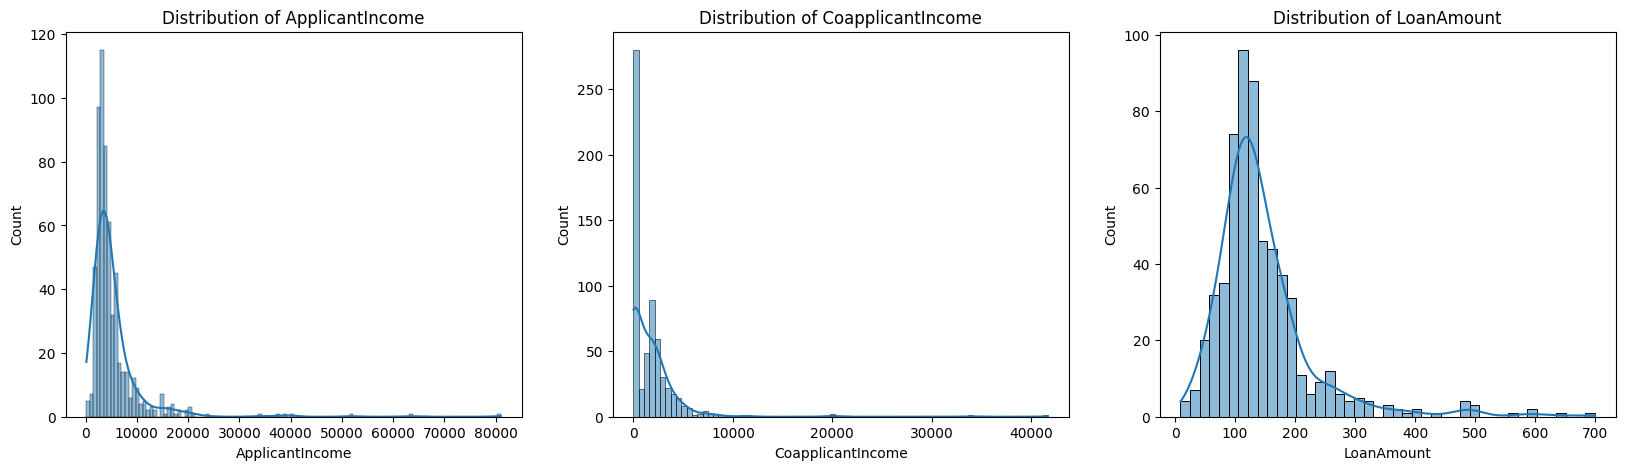

In [36]:
df = train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]

fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,features in enumerate(df):
    sns.histplot(data=train,x=features,ax=ax[i],kde=True)
    ax[i].set_title(f'Distribution of {features}')

* Applicant Income & Coapplicant Income have extreme outliers

In [37]:
bins = [0, 2500, 4000, 6000, 81000]
labels = ['Low', 'Average', 'High', 'Very high']

train['Income_bin'] = pd.cut(train['ApplicantIncome'], bins, labels=labels) #Here we added Income bin to our datadrame using pd.cut, which helps in binning

income_bin_crosstab = pd.crosstab(train['Income_bin'], train['Loan_Status'])

income_bin_normalized = income_bin_crosstab.div(income_bin_crosstab.sum(1).astype(float), axis=0)

fig = px.bar(income_bin_normalized,
             x=income_bin_normalized.index,
             y=['Y', 'N'],
             title='Loan Approval Status by Applicant Income',
             labels={'value': 'Percentage', 'variable': 'Loan Status'},
             category_orders={'Income_bin': labels},
             color_discrete_sequence=['green', 'red'],
             width=800, height=500)
fig.show()

It can be inferred that Applicant’s income does not affect the chances of loan approval much which is not so trivial as we assumed that if the applicant’s income is high the chances of loan approval will also be high.

In [38]:
count = (train['CoapplicantIncome'] == 0).sum()
count

273

We can see that 273 out of 614 rows do not have a coapplicant income. Hence, there may be cases in which applicant income is low but he also has a coapplicant, so he was granted a loan. Hence, a better parameter would be to create a new feature, total income.

In [39]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
bins = [0, 2500, 4000, 6000, 80000]
labels = ['Low', 'Average', 'High','Very High']

train['Total_Income_bin'] = pd.cut(train['Total_Income'], bins, labels=labels) #Here we added Total Income bin to our datadrame using pd.cut, which helps in binning

income_bin_crosstab = pd.crosstab(train['Total_Income_bin'], train['Loan_Status'])

income_bin_normalized = income_bin_crosstab.div(income_bin_crosstab.sum(1).astype(float), axis=0)

fig = px.bar(income_bin_normalized,
             x=income_bin_normalized.index,
             y=['Y', 'N'],
             title='Loan Approval Status by Applicant Income',
             labels={'value': 'Percentage', 'variable': 'Loan Status'},
             category_orders={'Total_Income_bin': labels},
             color_discrete_sequence=['green', 'red'],
             width=800, height=500)
fig.show()

We can see that Proportion of loans getting approved for applicants having low Total_Income is very less as compared to that of applicants with Average, High, and Very High Income.

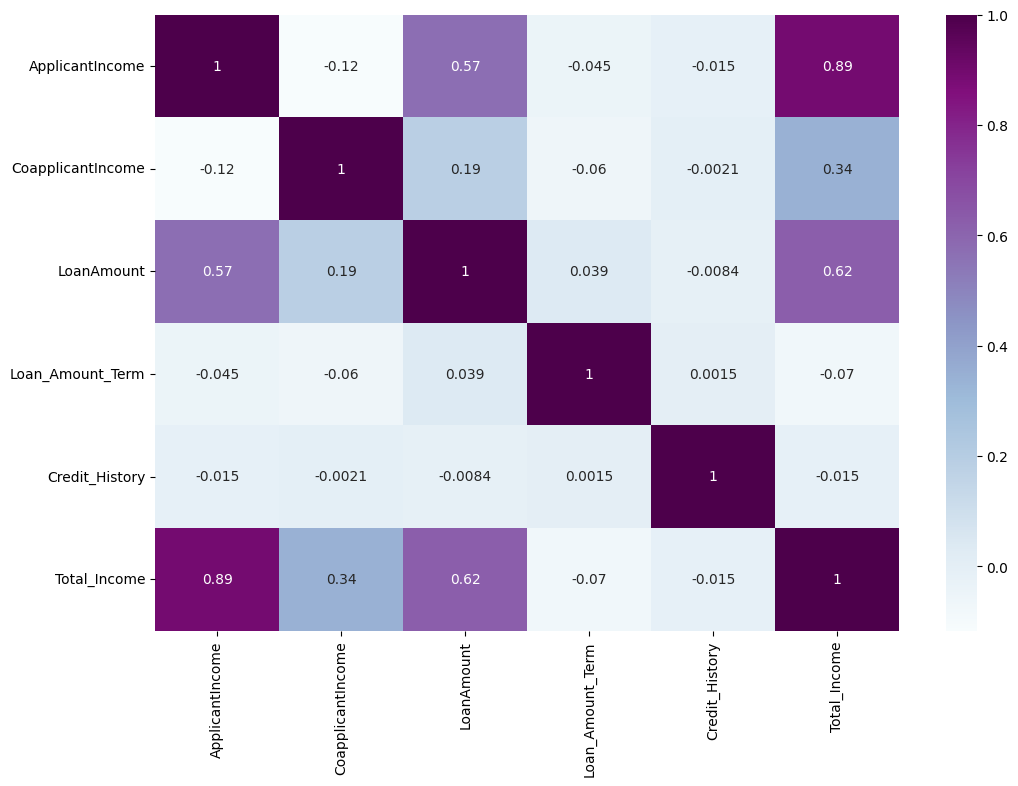

In [40]:
fig_dims=(12,8)
fig,ax=plt.subplots(figsize=fig_dims)

num_features=train.select_dtypes(include='number')
sns.heatmap(num_features.corr(),annot=True,ax=ax, cmap='BuPu')
plt.show()

### Missing Value Treatment

In [41]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
Income_bin            0
Total_Income          0
Total_Income_bin      1
dtype: int64

In [42]:
train=train.drop(['Total_Income_bin'], axis=1)

In [43]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
Income_bin            0
Total_Income          0
dtype: int64

Now we replace the categorical attributes with their mode

In [50]:
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

/var/folders/2s/v783hrsx7ld3cdp_cm9ghqd80000gn/T/ipykernel_72075/2988173929.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [51]:
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Income_bin           0
Total_Income         0
dtype: int64

In [52]:
train['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    526
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

We can see that the value 360 is being repeated very frequently for Loan_Amount_Term. Hence it would be a good idea to replace the missing values with the mode.

In [54]:
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

/var/folders/2s/v783hrsx7ld3cdp_cm9ghqd80000gn/T/ipykernel_72075/2271678739.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Since loan amount is a numerical attribute and it had some outliers value(as we can see in our previously plotted graph), we can consider median to be an appropriate value for missing values.

In [48]:
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

/var/folders/2s/v783hrsx7ld3cdp_cm9ghqd80000gn/T/ipykernel_72075/3228316714.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [55]:
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Income_bin           0
Total_Income         0
dtype: int64

### Handling Outliers